In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from models import ParticleNet
import torch
import torch.nn as nn
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import awkward as ak
import fastjet
import vector

In [8]:
datapath = '/xai4hepvol/toptagging/test/raw/test.h5'

In [68]:
N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

JET_ALGO = fastjet.kt_algorithm

jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

df = pd.read_hdf(f"{datapath}", key="table", start=1000, stop=1002)
print(f"{df['is_signal_new'].values=}")


def _col_list(prefix, max_particles=200):
    return ["%s_%d" % (prefix, i) for i in range(max_particles)]


vector.register_awkward()
px = ak.from_regular(ak.from_numpy(df[_col_list("PX")].values), axis=-1)
py = ak.from_regular(ak.from_numpy(df[_col_list("PY")].values), axis=-1)
pz = ak.from_regular(ak.from_numpy(df[_col_list("PZ")].values), axis=-1)
e = ak.from_regular(ak.from_numpy(df[_col_list("E")].values), axis=-1)
mask = e > 0

df['is_signal_new'].values=array([1, 1])


In [ ]:
n_jets = 10
for jet_idx in range(n_jets):
    px = ak.from_regular(ak.from_numpy(px[jet_idx]), axis=-1)
    py = ak.from_regular(ak.from_numpy(py[jet_idx]), axis=-1)
    pz = ak.from_regular(ak.from_numpy(pz[jet_idx]), axis=-1)
    e = ak.from_regular(ak.from_numpy(e[jet_idx]), axis=-1)
    
    array = ak.zip(
    {
        "px": px,
        "py": py,
        "pz": pz,
        "E": e,
        "particle_idx": ak.local_index(px),
        "subjet_idx": ak.zeros_like(px, dtype=int) - 1,
    },
    with_name="Momentum4D",
    )
    
    pseudojets = []
    for jet in array:
        pseudojets.append(
            [
                fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
                for particle in jet
            ]
        )
    print(f"{len(pseudojets)=}")
    print(f"{len(pseudojets[0])=}")  
  
    subjet_indices = []
    mapping = array.subjet_idx.to_list()
    for ijet, pseudojet in enumerate(pseudojets):
        subjet_indices.append([])
        cluster = fastjet.ClusterSequence(pseudojet, jetdef)

        # cluster jets
        jets = cluster.inclusive_jets()
        print(f"{len(jets)=}")
        assert len(jets) == 1

        # get the 3 exclusive jets
        subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
        print(f"{len(subjets)=}")
        assert len(subjets) == N_SUBJETS

        # sort by pt
        subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

        for subjet_idx, subjet in enumerate(subjets):
            subjet_indices[-1].append([])
            for subjet_const in subjet.constituents():
                for idx, jet_const in enumerate(pseudojet):
                    if (
                        subjet_const.px() == jet_const.px()
                        and subjet_const.py() == jet_const.py()
                        and subjet_const.pz() == jet_const.pz()
                        and subjet_const.E() == jet_const.E()
                    ):
                        subjet_indices[-1][-1].append(idx)

        for subjet_idx, subjet in enumerate(subjets):
            print(subjet_indices[ijet][subjet_idx])
            local_mapping = np.array(mapping[ijet])
            local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
            mapping[ijet] = local_mapping    

In [ ]:
# update array
# array.subjet_idx = ak.Array(mapping)
array = ak.zip(
    {
        "px": px,
        "py": py,
        "pz": pz,
        "E": e,
        "particle_idx": ak.local_index(px),
        "subjet_idx": ak.Array(mapping),
    },
    with_name="Momentum4D",
)

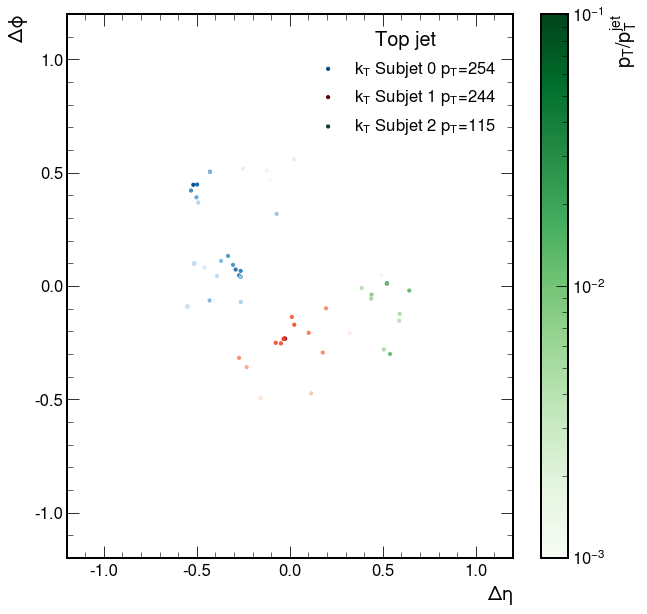

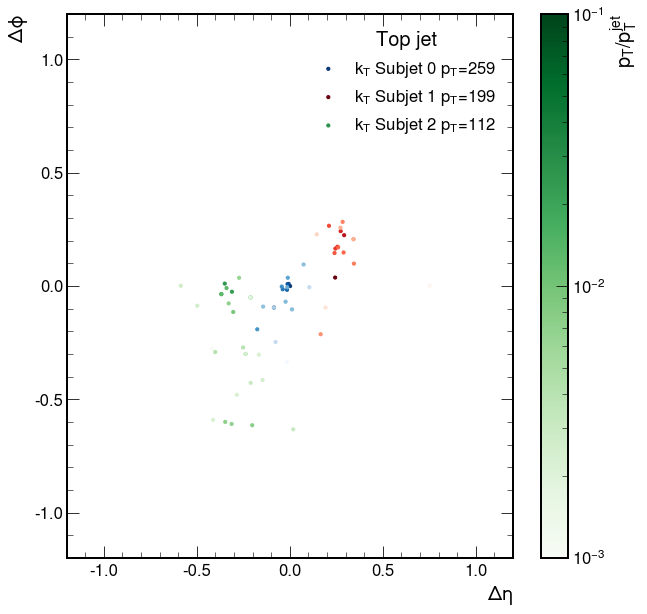

In [28]:


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

for i, arr in enumerate(array):
    fig = plt.figure()
    jet_vector = vector.obj(
        px=ak.sum(arr.px, axis=-1),
        py=ak.sum(arr.py, axis=-1),
        pz=ak.sum(arr.pz, axis=-1),
        E=ak.sum(arr.E, axis=-1),
    )
    subjet_vectors = [
        vector.obj(
            px=ak.sum(arr.px[arr.subjet_idx == j], axis=-1),
            py=ak.sum(arr.py[arr.subjet_idx == j], axis=-1),
            pz=ak.sum(arr.pz[arr.subjet_idx == j], axis=-1),
            E=ak.sum(arr.E[arr.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    deta = arr.deltaeta(jet_vector)
    dphi = arr.deltaphi(jet_vector)
    dpt = arr.pt / jet_vector.pt

    for j, cmap in zip(range(0, N_SUBJETS), ["Blues", "Reds", "Greens", "Purples"]):
        plt.scatter(
            deta[arr.subjet_idx == j],
            dphi[arr.subjet_idx == j],
            c=dpt[arr.subjet_idx == j],
            s=10,
            norm=colors.LogNorm(vmin=0.001, vmax=0.1),
            cmap=cmap,
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )
    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    plt.xlabel(r"$\Delta\eta$")
    plt.ylabel(r"$\Delta\phi$")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    plt.legend(title="Top jet" if df["is_signal_new"].values[i] == 1 else "QCD jet")
#     plt.savefig(f"etaphi_{i}.pdf")
#     plt.savefig(f"etaphi_{i}.png")

In [29]:
            deta[arr.subjet_idx == j]
,
            c=dpt[arr.subjet_idx == j],

In [31]:
            dphi[arr.subjet_idx == j]

<Array [-0.0359, 0.0107, ... -0.0507, -0.277] type='26 * float32'>

In [34]:
deta

<Array [0.244, 0.00169, ... -0.417, 0.751] type='62 * float32'>

In [35]:
arr.subjet_idx

<Array [1, 0, 0, 0, 0, 1, ... 1, 2, 1, 0, 2, 1] type='62 * int64'>

In [48]:
PATH = '/xai4hepvol/ParticleNet_6/before_training'

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/Rscores.pkl', 'rb') as handle:
    Rscores_list = pkl.load(handle)
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)

In [50]:
i = 0 

batch_y = batch_y_list[i]
#     if batch_y==score:

#         if c==1:
#             break    
#         c +=1            
batch_x = batch_x_list[i]
Rscores = Rscores_list[i]
R_edges = R_edges_list[i]
edge_index_dic = edge_index_list[i]
    
eta = batch_x[:, 0]
phi = batch_x[:, 1]
pt = np.abs(batch_x[:, 2])

eta_phi = batch_x[:, :2]

In [53]:
pseudojet = [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]

In [56]:
px = pt*torch.cos(phi)
py = pt*torch.sin(phi)
pz = pt*torch.sinh(eta)

In [62]:
jet

<MomentumArray4D [{px: 86.1, ... subjet_idx: -1}] type='62 * Momentum4D["px": fl...'>

In [63]:
pseudojet1 = [
            fastjet.PseudoJet(px[particle], py[particle], pz[particle], pz[particle])
            for particle in range(len(px))
        ]

TypeError: Wrong number or type of arguments for overloaded function 'new_PseudoJet'.
  Possible C/C++ prototypes are:
    fastjet::PseudoJet::PseudoJet()
    fastjet::PseudoJet::PseudoJet(double const,double const,double const,double const)
    fastjet::PseudoJet::PseudoJet(bool)


In [61]:
px[particle]

NameError: name 'particle' is not defined

In [ ]:
for particle in jet:
    

In [ ]:
array = ak.zip(
    {
        "px": px[mask],
        "py": py[mask],
        "pz": pz[mask],
        "E": e[mask],
        "mask": mask[mask],
        "particle_idx": ak.local_index(px[mask]),
        "subjet_idx": ak.zeros_like(px[mask], dtype=int) - 1,
    },
    with_name="Momentum4D",
)


pseudojet = 
        [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]


subjet_indices.append([])
cluster = fastjet.ClusterSequence(pseudojet, jetdef)

# cluster jets
jets = cluster.inclusive_jets()
print(f"{len(jets)=}")
assert len(jets) == 1

# get the 3 exclusive jets
subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
print(f"{len(subjets)=}")
assert len(subjets) == N_SUBJETS

# sort by pt
subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

for subjet_idx, subjet in enumerate(subjets):
    subjet_indices[-1].append([])
    for subjet_const in subjet.constituents():
        for idx, jet_const in enumerate(pseudojet):
            if (
                subjet_const.px() == jet_const.px()
                and subjet_const.py() == jet_const.py()
                and subjet_const.pz() == jet_const.pz()
                and subjet_const.E() == jet_const.E()
            ):
                subjet_indices[-1][-1].append(idx)

for subjet_idx, subjet in enumerate(subjets):
    print(subjet_indices[ijet][subjet_idx])
    local_mapping = np.array(mapping[ijet])
    local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
    mapping[ijet] = local_mapping